# Neural Network - Daily Taxi Demand Prediction

In this section we predict the daily demand of taxi trips in Chicago. 
The prediciton we perform by building a model are based on data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

We split the prediction into spatial units:
- Community Areas
- Hexagons with low resolution
- Hexagons with medium resolution
- Hexagons with high resolution

For each of the units we perform a seperate prediction based on data we have aggregeated in our preparation.

Our procedure in this part is structured in the following way:

- Explore different Neural Network architectures to find out which performs best. We do this based on Community areas.
- Hyperparameter tuning to find the best Neural Network Architecture
- Make predictions for all spatial units with the Architecture winner of the Hyperparametertuning
- Evaluation

<hr style="border: 1px solid #8888;">

In [1]:
# Import all necessary packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.stats import loguniform
import predictive as pred
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os.path

# Import keras libraries
import tensorflow
from tensorflow import keras
from keras import layers
import keras_tuner
from keras_tuner.tuners import Hyperband
import IPython

In [2]:
#pip install keras_tuner

<hr style="border: 1px solid #8888;">

## Preprocessing

In [3]:
# import datasets
df_24h_comar = pd.read_csv("../data/datasets/df_24h_comar.csv")
df_24h_hexlow = pd.read_csv("../data/datasets/df_24h_hexlow.csv")
df_24h_hexmed = pd.read_csv("../data/datasets/df_24h_hexmed.csv")
df_24h_hexhig = pd.read_csv("../data/datasets/df_24h_hexhig.csv")

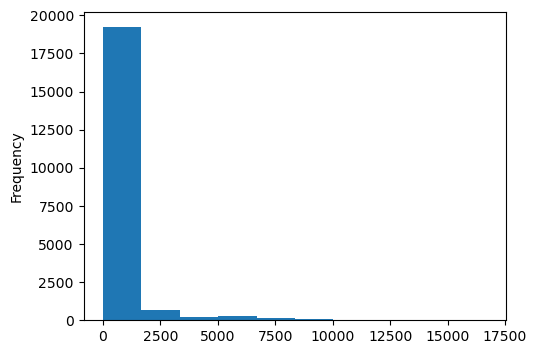

In [4]:
plt.figure(figsize=(12,4))

plt.subplot(121)
df_24h_comar['numOfTaxis_area'].plot.hist()

#plt.subplot(122)
#df_24h_comar['numOfTaxis_area'] = np.log(df_24h_comar['numOfTaxis_area'])
#df_24h_comar['numOfTaxis_area'].plot.hist()
plt.show()

Even if the distribution does not look good, we do not use the log transformation at this point, because only simple neural networks benefit from it, but more complex ones even become worse (**we have tested this!**).

In [5]:
#df_24h_hexlow['numOfTaxis_area'] = np.log(df_24h_hexlow['numOfTaxis_area'])
#df_24h_hexmed['numOfTaxis_area'] = np.log(df_24h_hexmed['numOfTaxis_area'])
#df_24h_hexhig['numOfTaxis_area'] = np.log(df_24h_hexhig['numOfTaxis_area'])

In [6]:
df_24h_comar.drop(columns = ['date_start'],inplace = True)
df_24h_hexlow.drop(columns = ['date_start'],inplace = True)
df_24h_hexmed.drop(columns = ['date_start'],inplace = True)
df_24h_hexhig.drop(columns = ['date_start'],inplace = True)

In [7]:
df_24h_comar = pred.dayandseas_to_int(df_24h_comar)
df_24h_hexlow = pred.dayandseas_to_int(df_24h_hexlow)
df_24h_hexmed = pred.dayandseas_to_int(df_24h_hexmed)
df_24h_hexhig = pred.dayandseas_to_int(df_24h_hexhig)

C:\Users\Benny\AppData\Local\Temp\ipykernel_23592\3784987082.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_24h_comar.drop(columns = ['numOfTaxis_area']).corr()


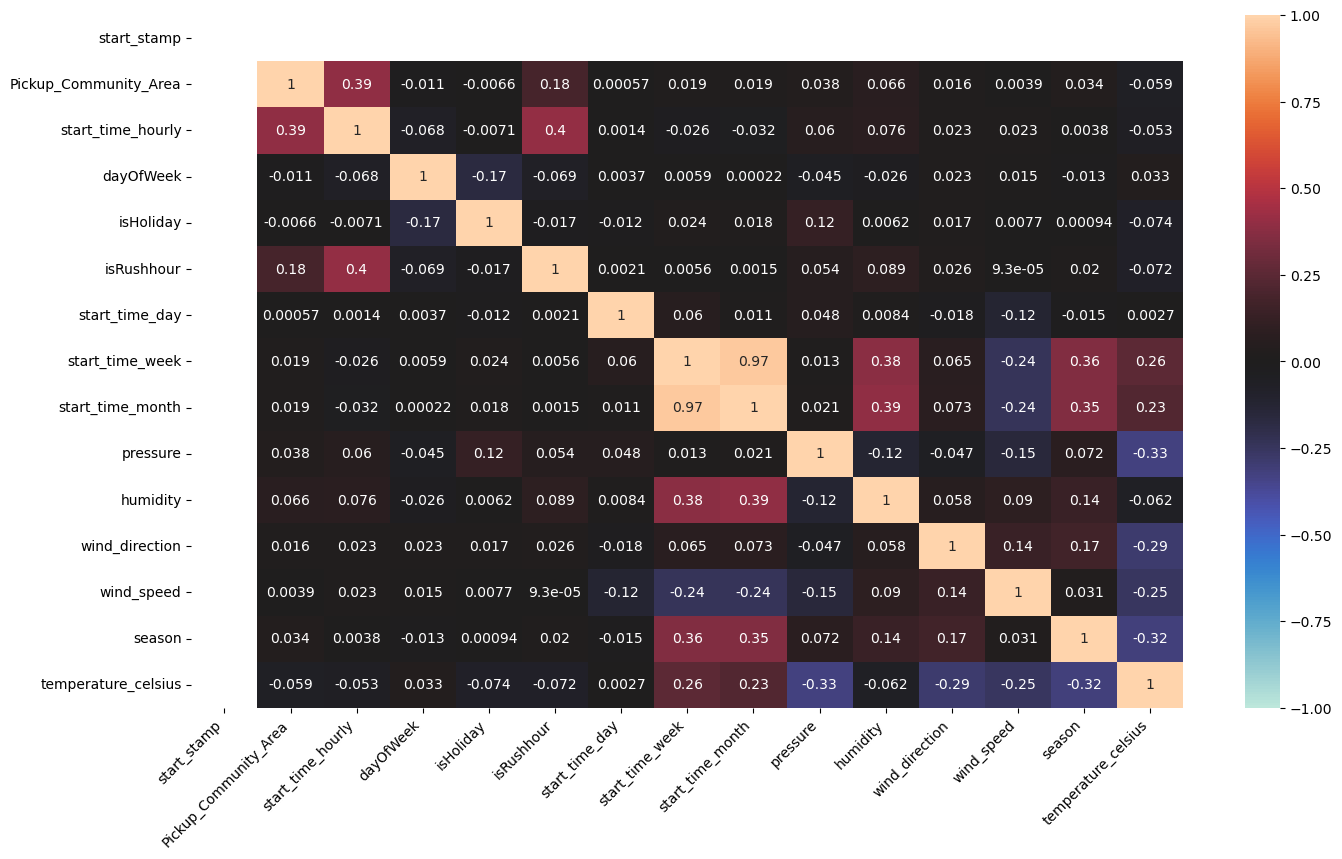

In [8]:
# correlation matrix of df_h_comar

import seaborn as sns
corr = df_24h_comar.drop(columns = ['numOfTaxis_area']).corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

We have a very high correlation between `start_time_month` and `start_time_week`, which leads to dropping `start_time_month`. The correlation matrix shows nothing for `start_stamp`, because for this feature every value is zero. This is beacuse we look at daily data and the column `start_stamp` represents the starting hour of an, here daily, interval. Because `start_stamp` is zero for every row and because we aren't interested in `start_time_hourly`, but in the daily demand, we drop both columns:

In [9]:
df_24h_comar.drop(columns = ['start_time_month'],inplace = True)

In [10]:
df_24h_comar.drop(columns = ['start_time_hourly'],inplace = True)

In [11]:
df_24h_comar.drop(columns = ['start_stamp'],inplace = True)

Doing the same for the dataframes of:

- hexagons with low resolution
- hexagons with medium resolution
- hexagons with high resolution

In [12]:
df_24h_hexlow.drop(columns = ['start_time_hourly','start_time_month','start_stamp'],inplace = True)
df_24h_hexmed.drop(columns = ['start_time_hourly','start_time_month','start_stamp'],inplace = True)
df_24h_hexhig.drop(columns = ['start_time_hourly','start_time_month','start_stamp'],inplace = True)

<hr style="border: 1px solid #8888;">

## General functions

In [13]:
def evaluate_performance(y_test,pred_ann,df):
    # Calculate MAE, RMSE & R2
    print("MAE:", round(mean_absolute_error(y_test,pred_ann), 4))
    print("RMSE:", round(mean_squared_error(y_test,pred_ann)**0.5, 4))
    print("R2:", round(r2_score(y_test,pred_ann), 4))
    print("Rough Accuracy Approximation:", round((1-(mean_absolute_error(y_test,pred_ann)/df["numOfTaxis_area"].mean()))*100,2), "%")

<hr style="border: 1px solid #8888;">

## 1. Daily Demand - Community Area

- Before running you have to install tensorflow: `pip install tensorflow`

### **Feature engineering**

Here we will shortly create dummy variables and split the data and normalize it

In [14]:
df_24h_comar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20740 entries, 0 to 20739
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Pickup_Community_Area  20740 non-null  float64
 1   numOfTaxis_area        20740 non-null  int64  
 2   dayOfWeek              20740 non-null  int64  
 3   isHoliday              20740 non-null  bool   
 4   isRushhour             20740 non-null  bool   
 5   start_time_day         20740 non-null  int64  
 6   start_time_week        20740 non-null  int64  
 7   pressure               20740 non-null  float64
 8   humidity               20740 non-null  float64
 9   wind_direction         20740 non-null  float64
 10  wind_speed             20740 non-null  float64
 11  description            20740 non-null  object 
 12  season                 20740 non-null  int64  
 13  temperature_celsius    20740 non-null  float64
dtypes: bool(2), float64(6), int64(5), object(1)
memory usa

In [15]:
# Prepare variables for dummy creation
df_24h_comar['Pickup_Community_Area'] = df_24h_comar['Pickup_Community_Area'].astype(str)
df_24h_comar['dayOfWeek'] = df_24h_comar['dayOfWeek'].astype(str)
df_24h_comar['start_time_day'] = df_24h_comar['start_time_day'].astype(str)
df_24h_comar['start_time_week'] = df_24h_comar['start_time_week'].astype(str)
df_24h_comar['season'] = df_24h_comar['season'].astype(str)
df_24h_comar['description'] = df_24h_comar['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_24h_comar = pd.get_dummies(df_24h_comar)
df_24h_comar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20740 entries, 0 to 20739
Columns: 203 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(195)
memory usage: 4.8 MB


In [16]:
df_24h_comar

,numOfTaxis_area,isHoliday,isRushhour,pressure,humidity,wind_direction,wind_speed,temperature_celsius,Pickup_Community_Area_1.0,Pickup_Community_Area_10.0,...,description_snow,description_thunderstorm,description_thunderstorm with heavy rain,description_thunderstorm with light rain,description_thunderstorm with rain,description_very heavy rain,season_0,season_1,season_2,season_3
0,153,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
1,72,True,False,1024.0,64.0,200.0,4.0,-0.19,0,0,...,0,0,0,0,0,0,0,1,0,0
2,701,True,False,1024.0,64.0,200.0,4.0,-0.19,0,0,...,0,0,0,0,0,0,0,1,0,0
3,237,True,False,1024.0,64.0,200.0,4.0,-0.19,0,0,...,0,0,0,0,0,0,0,1,0,0
4,353,True,False,1024.0,64.0,200.0,4.0,-0.19,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20735,3,False,True,1022.0,89.0,319.0,1.0,-13.21,0,0,...,0,0,0,0,0,0,0,1,0,0
20736,4,False,False,1022.0,89.0,259.0,1.0,-12.53,0,0,...,0,0,0,0,0,0,0,1,0,0
20737,1,False,False,1022.0,89.0,287.0,0.0,-12.46,0,0,...,0,0,0,0,0,0,0,1,0,0
20738,158,False,False,1023.0,89.0,219.0,0.0,-10.44,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
# Set output frame and input frame
x = df_24h_comar.drop('numOfTaxis_area', axis=1)
y = df_24h_comar['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

**We now have the following datasets:**
- x_train, y_train &rarr; 50% input features for training the model
- x_val, y_val &rarr; 20% to select hyperparameters
- x_test, y_test &rarr; 30% to control the accurancy of the model

<hr style="border: 0.5px solid #8888;">

### Exploration of the model: Checking for the best Neural Network Architecture
- Exploration: We will start with some very simple Neural Network designs and gradually increase its complexity by adding more layers and nodes
- Later we will just use the Hyperband tuning algorithm, which is similar to Gridsearch, to do this work for us and decide for the best hyperparameters

#### Exploration: Very Simple Neural Network (1 Hidden Layer with 1 Node)

In [18]:
# Input Layer
inputs = keras.Input(shape=(202,)) # shapesize dependent of input feature count

# Just 1 Hidden Layer
x = layers.Dense(1, activation='relu')(inputs)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

Define a callback that stops earlier if there is no further improvement, restores the model weights from the epoch with the best value of val_loss, and prevents overfitting by monitoring val_loss:

In [19]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=20,
    restore_best_weights=True
    )

In [20]:
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
325/325 [==============================] - 1s 1ms/step - loss: 2141301.2500 - val_loss: 2093138.6250
Epoch 2/100
325/325 [==============================] - 0s 861us/step - loss: 2137271.0000 - val_loss: 2087039.1250
Epoch 3/100
325/325 [==============================] - 0s 827us/step - loss: 2129387.0000 - val_loss: 2077473.6250
Epoch 4/100
325/325 [==============================] - 0s 824us/step - loss: 2118225.2500 - val_loss: 2064841.8750
Epoch 5/100
325/325 [==============================] - 0s 821us/step - loss: 2104287.2500 - val_loss: 2049781.8750
Epoch 6/100
325/325 [==============================] - 0s 830us/step - loss: 2087923.1250 - val_loss: 2032437.7500
Epoch 7/100
325/325 [==============================] - 0s 821us/step - loss: 2069177.7500 - val_loss: 2012674.1250
Epoch 8/100
325/325 [==============================] - 0s 812us/step - loss: 2048333.0000 - val_loss: 1991141.7500
Epoch 9/100
325/325 [==============================] - 0s 815us/step - loss: 20258

325/325 [==============================] - 0s 803us/step - loss: 597058.6875 - val_loss: 536468.6875
Epoch 73/100
325/325 [==============================] - 0s 803us/step - loss: 585615.0625 - val_loss: 524943.0000
Epoch 74/100
325/325 [==============================] - 0s 796us/step - loss: 574404.4375 - val_loss: 513730.8750
Epoch 75/100
325/325 [==============================] - 0s 815us/step - loss: 563115.8750 - val_loss: 502674.3438
Epoch 76/100
325/325 [==============================] - 0s 812us/step - loss: 552644.7500 - val_loss: 492282.6562
Epoch 77/100
325/325 [==============================] - 0s 803us/step - loss: 542308.3125 - val_loss: 481881.3750
Epoch 78/100
325/325 [==============================] - 0s 806us/step - loss: 532094.2500 - val_loss: 471771.2188
Epoch 79/100
325/325 [==============================] - 0s 803us/step - loss: 522064.4688 - val_loss: 461998.7812
Epoch 80/100
325/325 [==============================] - 0s 812us/step - loss: 512098.5938 - val_loss:

In [21]:
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_24h_comar)

195/195 [==============================] - 0s 490us/step
MAE: 209.0676
RMSE: 601.4931
R2: 0.8231
Rough Accuracy Approximation: 51.68 %


#### Exploration: Simple Neural Network (1 Hidden Layer with 8 Nodes)

In [22]:
# Input Layer
inputs = keras.Input(shape=(202,)) # shapesize dependent of input feature count

# Just 1 Hidden Layer
x = layers.Dense(8, activation='relu')(inputs)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
325/325 [==============================] - 1s 1ms/step - loss: 2139847.5000 - val_loss: 2088681.8750
Epoch 2/100
325/325 [==============================] - 0s 824us/step - loss: 2125446.2500 - val_loss: 2064498.7500
Epoch 3/100
325/325 [==============================] - 0s 812us/step - loss: 2089820.3750 - val_loss: 2018595.6250
Epoch 4/100
325/325 [==============================] - 0s 821us/step - loss: 2036444.1250 - val_loss: 1959756.6250
Epoch 5/100
325/325 [==============================] - 0s 818us/step - loss: 1971270.7500 - val_loss: 1889864.7500
Epoch 6/100
325/325 [==============================] - 0s 815us/step - loss: 1896746.6250 - val_loss: 1813861.2500
Epoch 7/100
325/325 [==============================] - 0s 815us/step - loss: 1817775.6250 - val_loss: 1733567.8750
Epoch 8/100
325/325 [==============================] - 0s 815us/step - loss: 1735075.3750 - val_loss: 1650933.5000
Epoch 9/100
325/325 [==============================] - 0s 815us/step - loss: 16502

325/325 [==============================] - 0s 830us/step - loss: 150454.4219 - val_loss: 159171.5625
Epoch 73/100
325/325 [==============================] - 0s 830us/step - loss: 149273.4531 - val_loss: 158242.2344
Epoch 74/100
325/325 [==============================] - 0s 827us/step - loss: 148152.7031 - val_loss: 157420.6406
Epoch 75/100
325/325 [==============================] - 0s 843us/step - loss: 146978.2812 - val_loss: 156525.2656
Epoch 76/100
325/325 [==============================] - 0s 855us/step - loss: 145838.8281 - val_loss: 155489.2969
Epoch 77/100
325/325 [==============================] - 0s 871us/step - loss: 144638.8438 - val_loss: 154564.8750
Epoch 78/100
325/325 [==============================] - 0s 858us/step - loss: 143404.8906 - val_loss: 153605.7656
Epoch 79/100
325/325 [==============================] - 0s 867us/step - loss: 142296.9375 - val_loss: 152683.2812
Epoch 80/100
325/325 [==============================] - 0s 905us/step - loss: 141252.2500 - val_loss:

In [23]:
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_24h_comar)

195/195 [==============================] - 0s 485us/step
MAE: 131.4246
RMSE: 385.0533
R2: 0.9275
Rough Accuracy Approximation: 69.63 %


#### Exploration: Neural Network (1 Hidden Layer with 512 Nodes)

In [24]:
# Input Layer
inputs = keras.Input(shape=(202,)) # shapesize dependent of input feature count

# Just 1 Hidden Layer
x = layers.Dense(512, activation='relu')(inputs)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
325/325 [==============================] - 1s 1ms/step - loss: 1989955.0000 - val_loss: 1593761.7500
Epoch 2/100
325/325 [==============================] - 0s 1ms/step - loss: 1202867.2500 - val_loss: 814215.6875
Epoch 3/100
325/325 [==============================] - 0s 1ms/step - loss: 658318.1875 - val_loss: 453026.7188
Epoch 4/100
325/325 [==============================] - 0s 1ms/step - loss: 387848.2188 - val_loss: 270188.6875
Epoch 5/100
325/325 [==============================] - 0s 1ms/step - loss: 248825.4375 - val_loss: 190621.2969
Epoch 6/100
325/325 [==============================] - 0s 1ms/step - loss: 189072.5000 - val_loss: 159356.1094
Epoch 7/100
325/325 [==============================] - 0s 1ms/step - loss: 164227.0156 - val_loss: 148251.8594
Epoch 8/100
325/325 [==============================] - 0s 1ms/step - loss: 151662.0625 - val_loss: 142655.9062
Epoch 9/100
325/325 [==============================] - 0s 1ms/step - loss: 144069.7969 - val_loss: 138939.078

325/325 [==============================] - 0s 1ms/step - loss: 24829.5156 - val_loss: 60304.6406
Epoch 76/100
325/325 [==============================] - 0s 1ms/step - loss: 23956.8516 - val_loss: 60130.1406
Epoch 77/100
325/325 [==============================] - 0s 1ms/step - loss: 23860.6816 - val_loss: 58851.2617
Epoch 78/100
325/325 [==============================] - 0s 1ms/step - loss: 23140.5645 - val_loss: 58607.0586
Epoch 79/100
325/325 [==============================] - 0s 1ms/step - loss: 22392.9199 - val_loss: 58157.4844
Epoch 80/100
325/325 [==============================] - 0s 1ms/step - loss: 21848.6328 - val_loss: 57915.4414
Epoch 81/100
325/325 [==============================] - 0s 1ms/step - loss: 21509.4180 - val_loss: 57996.0508
Epoch 82/100
325/325 [==============================] - 0s 1ms/step - loss: 21023.2031 - val_loss: 56940.5820
Epoch 83/100
325/325 [==============================] - 0s 1ms/step - loss: 20471.4434 - val_loss: 56778.7500
Epoch 84/100
325/325 [=

In [25]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_24h_comar)

195/195 [==============================] - 0s 536us/step
MAE: 77.9088
RMSE: 214.4476
R2: 0.9775
Rough Accuracy Approximation: 82.0 %


#### Exploration: Neural Network (3 Hidden Layer with 256 Nodes)

In [26]:
# Input Layer
inputs = keras.Input(shape=(202,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
325/325 [==============================] - 1s 2ms/step - loss: 809449.1250 - val_loss: 159464.9062
Epoch 2/100
325/325 [==============================] - 0s 1ms/step - loss: 153799.1719 - val_loss: 134867.3906
Epoch 3/100
325/325 [==============================] - 0s 1ms/step - loss: 122049.7188 - val_loss: 119801.6484
Epoch 4/100
325/325 [==============================] - 0s 1ms/step - loss: 93758.4297 - val_loss: 96187.9922
Epoch 5/100
325/325 [==============================] - 0s 1ms/step - loss: 63358.1719 - val_loss: 86480.1797
Epoch 6/100
325/325 [==============================] - 0s 1ms/step - loss: 42078.8750 - val_loss: 66893.2188
Epoch 7/100
325/325 [==============================] - 0s 1ms/step - loss: 28342.4023 - val_loss: 62785.8086
Epoch 8/100
325/325 [==============================] - 0s 1ms/step - loss: 23992.6406 - val_loss: 51472.8594
Epoch 9/100
325/325 [==============================] - 0s 1ms/step - loss: 18178.6055 - val_loss: 45673.6523
Epoch 10/100


Epoch 76/100
325/325 [==============================] - 0s 1ms/step - loss: 2032.6049 - val_loss: 30071.2520
Epoch 77/100
325/325 [==============================] - 0s 1ms/step - loss: 3480.6091 - val_loss: 32088.9277
Epoch 78/100
325/325 [==============================] - 0s 1ms/step - loss: 5270.3770 - val_loss: 30223.6992
Epoch 79/100
325/325 [==============================] - 0s 1ms/step - loss: 3400.4055 - val_loss: 29435.8652
Epoch 80/100
325/325 [==============================] - 0s 1ms/step - loss: 3540.6482 - val_loss: 31576.8340
Epoch 81/100
325/325 [==============================] - 0s 1ms/step - loss: 3852.6233 - val_loss: 29062.5859
Epoch 82/100
325/325 [==============================] - 0s 1ms/step - loss: 3224.6597 - val_loss: 28838.9375
Epoch 83/100
325/325 [==============================] - 0s 1ms/step - loss: 3214.8679 - val_loss: 28056.9629
Epoch 84/100
325/325 [==============================] - 0s 1ms/step - loss: 3848.0339 - val_loss: 28437.3789
Epoch 85/100
325/32

In [27]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_24h_comar)

195/195 [==============================] - 0s 624us/step
MAE: 47.478
RMSE: 162.2861
R2: 0.9871
Rough Accuracy Approximation: 89.03 %


#### Exploration: Complex Neural Network (8 Hidden Layer with mixed number of Nodes)

In [28]:
# Input Layer
inputs = keras.Input(shape=(202,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
325/325 [==============================] - 2s 4ms/step - loss: 669887.0625 - val_loss: 158377.3906
Epoch 2/100
325/325 [==============================] - 1s 4ms/step - loss: 143804.3125 - val_loss: 140085.2969
Epoch 3/100
325/325 [==============================] - 1s 4ms/step - loss: 85363.9062 - val_loss: 80487.4375
Epoch 4/100
325/325 [==============================] - 1s 4ms/step - loss: 62896.1133 - val_loss: 122391.6719
Epoch 5/100
325/325 [==============================] - 1s 4ms/step - loss: 67650.7578 - val_loss: 69654.0703
Epoch 6/100
325/325 [==============================] - 1s 5ms/step - loss: 38931.8203 - val_loss: 61189.8359
Epoch 7/100
325/325 [==============================] - 1s 4ms/step - loss: 32697.3125 - val_loss: 49364.5742
Epoch 8/100
325/325 [==============================] - 1s 4ms/step - loss: 43045.3711 - val_loss: 123736.8828
Epoch 9/100
325/325 [==============================] - 1s 4ms/step - loss: 67157.4062 - val_loss: 53323.8320
Epoch 10/100


In [29]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_24h_comar)

195/195 [==============================] - 0s 1ms/step
MAE: 45.7767
RMSE: 163.7832
R2: 0.9869
Rough Accuracy Approximation: 89.42 %


<hr style="border: 0.5px solid #8888;">

### 1.3 Hyperparameter Tuning for the best model (in terms of best metric)

**Building the model with the functional API of Keras:**

In [30]:
def build_model(hp):
    # Input Layer
    inputs = keras.Input(shape=(202,)) # shapesize dependent of input feature count
    
    # Hidden Layers
    ## Initialize x
    x = inputs
    
    ## Possible Hidden Layers
    for i in range(hp.Int('total_hidden_layers', 0, 10)):
        layer_name = 'hidden_layer_' + str(i+1)
        if i in [0,1,2]:
            x = layers.Dense(units=hp.Choice(layer_name + '_units', values=[256, 512]), activation='relu')(x)
        elif i in [3,4,5]:
            x = layers.Dense(units=hp.Choice(layer_name + '_units', values=[128, 256]), activation='relu')(x)
        elif i in [6,7,8,9]:
            x = layers.Dense(units=hp.Choice(layer_name + '_units', values=[32, 64, 128]), activation='relu')(x)
    
    # Output Layer
    output = layers.Dense(1, activation='relu')(x)
    
    # Instantiate the model
    model_ann = keras.Model(inputs, output, name='daily_taxi_demand_chicago')
    
    # Compile the model
    model_ann.compile(optimizer='Adam', loss='mean_squared_error')
    
    return model_ann

**Use hyperparameter tuning to find the best model:**

Instantiate a tuner to perform hyperparametertuning:

The Keras Tuner has four tuners available - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`.  
We will use `Hyperband` because the Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model.

In [31]:
tuner = Hyperband(
    build_model,
    objective = 'val_loss',
    max_epochs = 30,
    factor = 3,
    executions_per_trial = 1,
    directory = os.path.normpath('C:/AAA_LOG'),
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
    )

Display search space overview:

In [32]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
total_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': 'linear'}


Define a callback to clear the training outputs at the end of every training step:

In [33]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Run the hyperparameter search:

In [34]:
tuner.search(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    callbacks = [ClearTrainingOutput()]
    )

Trial 90 Complete [00h 00m 25s]
val_loss: 32325.1796875

Best val_loss So Far: 29870.078125
Total elapsed time: 00h 11m 07s
INFO:tensorflow:Oracle triggered exit


Display the best models, their hyperparameters, and the resulting metrics:

In [35]:
tuner.results_summary()

Results summary
Results in C:\AAA_LOG\kerastuner_LOG
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0073 summary
Hyperparameters:
total_hidden_layers: 7
hidden_layer_1_units: 256
hidden_layer_2_units: 512
hidden_layer_3_units: 256
hidden_layer_4_units: 128
hidden_layer_5_units: 256
hidden_layer_6_units: 128
hidden_layer_7_units: 128
hidden_layer_8_units: 32
hidden_layer_9_units: 32
hidden_layer_10_units: 128
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0068
Score: 29870.078125

Trial 0085 summary
Hyperparameters:
total_hidden_layers: 6
hidden_layer_1_units: 512
hidden_layer_2_units: 256
hidden_layer_3_units: 256
hidden_layer_4_units: 128
hidden_layer_5_units: 128
hidden_layer_6_units: 256
hidden_layer_7_units: 64
hidden_layer_8_units: 32
hidden_layer_9_units: 64
hidden_layer_10_units: 32
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 30496.30859375

Trial 0050 summary
Hyperparameters:

Get the optimal hyperparameters:

In [36]:
ann_best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {ann_best_hps.get('hidden_layer_1_units')} 
and the total number of hidden layers is {ann_best_hps.get('total_hidden_layers')}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is 256 
and the total number of hidden layers is 7.



Get the best model:

In [37]:
model_ann = tuner.get_best_models(num_models=1)[0]

Show the model summary:

In [38]:
model_ann.summary()

Model: "daily_taxi_demand_chicago"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 202)]             0         
                                                                 
 dense (Dense)               (None, 256)               51968     
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 128) 

**Train the model:**

For **performance reasons**, the model was **only trained for 30 epochs** in hyperparameter tuning.  
That is why we are **now continuing to train** the model to achieve the **best possible result**.

Define a callback that stops earlier if there is no further improvement, restores the model weights from the epoch with the best value of val_loss, and prevents overfitting by monitoring val_loss:

In [39]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=100, 
    restore_best_weights=True 
    )

In [40]:
model_ann.fit(x_train, y_train, epochs=500, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/500
325/325 [==============================] - 2s 3ms/step - loss: 27912.5977 - val_loss: 43704.5977
Epoch 2/500
325/325 [==============================] - 1s 2ms/step - loss: 22689.4707 - val_loss: 59574.1875
Epoch 3/500
325/325 [==============================] - 1s 2ms/step - loss: 14317.5176 - val_loss: 38329.3359
Epoch 4/500
325/325 [==============================] - 1s 2ms/step - loss: 30156.2891 - val_loss: 46157.3906
Epoch 5/500
325/325 [==============================] - 1s 3ms/step - loss: 18236.8320 - val_loss: 37095.4922
Epoch 6/500
325/325 [==============================] - 1s 2ms/step - loss: 16091.2998 - val_loss: 35719.3516
Epoch 7/500
325/325 [==============================] - 1s 2ms/step - loss: 21252.1172 - val_loss: 34525.7188
Epoch 8/500
325/325 [==============================] - 1s 2ms/step - loss: 14882.9121 - val_loss: 53791.1836
Epoch 9/500
325/325 [==============================] - 1s 2ms/step - loss: 19688.9922 - val_loss: 35344.6289
Epoch 10/500
325/32

Epoch 76/500
325/325 [==============================] - 1s 2ms/step - loss: 3835.0498 - val_loss: 24891.9180
Epoch 77/500
325/325 [==============================] - 1s 2ms/step - loss: 3363.2849 - val_loss: 25261.3418
Epoch 78/500
325/325 [==============================] - 1s 2ms/step - loss: 3543.3591 - val_loss: 29406.5410
Epoch 79/500
325/325 [==============================] - 1s 2ms/step - loss: 6903.4482 - val_loss: 29443.6523
Epoch 80/500
325/325 [==============================] - 1s 2ms/step - loss: 4750.6836 - val_loss: 24706.2441
Epoch 81/500
325/325 [==============================] - 1s 2ms/step - loss: 4171.9917 - val_loss: 29938.1367
Epoch 82/500
325/325 [==============================] - 1s 2ms/step - loss: 7171.3198 - val_loss: 27057.6953
Epoch 83/500
325/325 [==============================] - 1s 2ms/step - loss: 9275.4473 - val_loss: 29800.1152
Epoch 84/500
325/325 [==============================] - 1s 2ms/step - loss: 6645.7295 - val_loss: 27154.8008
Epoch 85/500
325/32

325/325 [==============================] - 1s 2ms/step - loss: 2726.6992 - val_loss: 24824.9414
Epoch 151/500
325/325 [==============================] - 1s 2ms/step - loss: 2339.7615 - val_loss: 25112.3594
Epoch 152/500
325/325 [==============================] - 1s 2ms/step - loss: 2429.9041 - val_loss: 25472.9902
Epoch 153/500
325/325 [==============================] - 1s 2ms/step - loss: 3916.3276 - val_loss: 25315.1348
Epoch 154/500
325/325 [==============================] - 1s 2ms/step - loss: 4239.1294 - val_loss: 22996.8125
Epoch 155/500
325/325 [==============================] - 1s 2ms/step - loss: 1822.7266 - val_loss: 24041.1289
Epoch 156/500
325/325 [==============================] - 1s 2ms/step - loss: 2282.9070 - val_loss: 26641.2988
Epoch 157/500
325/325 [==============================] - 1s 2ms/step - loss: 3352.9988 - val_loss: 27414.0938
Epoch 158/500
325/325 [==============================] - 1s 2ms/step - loss: 4652.5781 - val_loss: 24847.4727
Epoch 159/500
325/325 [=

325/325 [==============================] - 1s 2ms/step - loss: 1241.5908 - val_loss: 23839.7891
Epoch 225/500
325/325 [==============================] - 1s 2ms/step - loss: 3322.6150 - val_loss: 27067.8965
Epoch 226/500
325/325 [==============================] - 1s 2ms/step - loss: 2210.4543 - val_loss: 24462.1250
Epoch 227/500
325/325 [==============================] - 1s 2ms/step - loss: 2462.6829 - val_loss: 29767.9238
Epoch 228/500
325/325 [==============================] - 1s 2ms/step - loss: 2707.2397 - val_loss: 23860.0254
Epoch 229/500
325/325 [==============================] - 1s 2ms/step - loss: 2084.6213 - val_loss: 24102.8242
Epoch 230/500
325/325 [==============================] - 1s 2ms/step - loss: 1820.9309 - val_loss: 24420.1133
Epoch 231/500
325/325 [==============================] - 1s 2ms/step - loss: 1609.0913 - val_loss: 24293.2949
Epoch 232/500
325/325 [==============================] - 1s 2ms/step - loss: 1572.0521 - val_loss: 23864.0371
Epoch 233/500
325/325 [=

Epoch 299/500
325/325 [==============================] - 1s 2ms/step - loss: 562.4835 - val_loss: 23936.0508
Epoch 300/500
325/325 [==============================] - 1s 2ms/step - loss: 472.4522 - val_loss: 24901.7695
Epoch 301/500
325/325 [==============================] - 1s 2ms/step - loss: 2885.5310 - val_loss: 24766.7207
Epoch 302/500
325/325 [==============================] - 1s 2ms/step - loss: 3078.8301 - val_loss: 22767.1016
Epoch 303/500
325/325 [==============================] - 1s 2ms/step - loss: 1865.7959 - val_loss: 23851.7930
Epoch 304/500
325/325 [==============================] - 1s 2ms/step - loss: 785.0537 - val_loss: 23596.6445
Epoch 305/500
325/325 [==============================] - 1s 2ms/step - loss: 527.9908 - val_loss: 24430.6621
Epoch 306/500
325/325 [==============================] - 1s 2ms/step - loss: 750.4496 - val_loss: 24237.6484
Epoch 307/500
325/325 [==============================] - 1s 2ms/step - loss: 1278.1868 - val_loss: 23828.1582
Epoch 308/500
3

325/325 [==============================] - 1s 2ms/step - loss: 1123.8326 - val_loss: 24657.3887
Epoch 374/500
325/325 [==============================] - 1s 2ms/step - loss: 5553.3047 - val_loss: 23990.5723
Epoch 375/500
325/325 [==============================] - 1s 2ms/step - loss: 1349.0951 - val_loss: 24183.6445
Epoch 376/500
325/325 [==============================] - 1s 2ms/step - loss: 1286.5099 - val_loss: 28974.4941
Epoch 377/500
325/325 [==============================] - 1s 3ms/step - loss: 915.2153 - val_loss: 24057.1289
Epoch 378/500
325/325 [==============================] - 1s 3ms/step - loss: 290.3447 - val_loss: 23289.0918
Epoch 379/500
325/325 [==============================] - 1s 3ms/step - loss: 1930.3269 - val_loss: 27858.2812
Epoch 380/500
325/325 [==============================] - 1s 3ms/step - loss: 1393.9247 - val_loss: 23635.5352
Epoch 381/500
325/325 [==============================] - 1s 2ms/step - loss: 2247.0442 - val_loss: 26629.7539
Epoch 382/500
325/325 [===

Epoch 448/500
325/325 [==============================] - 1s 2ms/step - loss: 693.7449 - val_loss: 24463.9590
Epoch 449/500
325/325 [==============================] - 1s 2ms/step - loss: 1295.0168 - val_loss: 24441.3398
Epoch 450/500
325/325 [==============================] - 1s 2ms/step - loss: 1514.7693 - val_loss: 26300.1152
Epoch 451/500
325/325 [==============================] - 1s 2ms/step - loss: 1311.2258 - val_loss: 23791.3398
Epoch 452/500
325/325 [==============================] - 1s 2ms/step - loss: 1434.1145 - val_loss: 23639.1270
Epoch 453/500
325/325 [==============================] - 1s 2ms/step - loss: 1517.5543 - val_loss: 23927.1504
Epoch 454/500
325/325 [==============================] - 1s 2ms/step - loss: 1025.5054 - val_loss: 23996.6074
Epoch 455/500
325/325 [==============================] - 1s 2ms/step - loss: 1040.4603 - val_loss: 23398.3086
Epoch 456/500
325/325 [==============================] - 1s 2ms/step - loss: 537.0508 - val_loss: 27737.4395
Epoch 457/50

### Evaluation: Daily Demand - Community Area

In [41]:
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_24h_comar)

195/195 [==============================] - 0s 990us/step
MAE: 40.9383
RMSE: 145.6777
R2: 0.9896
Rough Accuracy Approximation: 90.54 %


### NOTE:
- The architecture from this Hyperparametertuning will be used as the baseline architecture for the following spatial-unit comparisons!

<hr style="border: 0.5px solid #8888;">


## 2. Daily Demand - hexagon low resolution

- The architecture of the hyperparametertuning from Community Area will be adapted and used here!

### **Feature engineering**

In [42]:
df_24h_hexlow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   h3_hex_id_low_res    7344 non-null   object 
 1   numOfTaxis_area      7344 non-null   int64  
 2   dayOfWeek            7344 non-null   int64  
 3   isHoliday            7344 non-null   bool   
 4   isRushhour           7344 non-null   bool   
 5   start_time_day       7344 non-null   int64  
 6   start_time_week      7344 non-null   int64  
 7   pressure             7344 non-null   float64
 8   humidity             7344 non-null   float64
 9   wind_direction       7344 non-null   float64
 10  wind_speed           7344 non-null   float64
 11  description          7344 non-null   object 
 12  season               7344 non-null   int64  
 13  temperature_celsius  7344 non-null   float64
dtypes: bool(2), float64(5), int64(5), object(2)
memory usage: 703.0+ KB


In [43]:
# Prepare variables for dummy creation
df_24h_hexlow['h3_hex_id_low_res'] = df_24h_hexlow['h3_hex_id_low_res'].astype(str)
df_24h_hexlow['dayOfWeek'] = df_24h_hexlow['dayOfWeek'].astype(str)
df_24h_hexlow['start_time_day'] = df_24h_hexlow['start_time_day'].astype(str)
df_24h_hexlow['start_time_week'] = df_24h_hexlow['start_time_week'].astype(str)
df_24h_hexlow['season'] = df_24h_hexlow['season'].astype(str)
df_24h_hexlow['description'] = df_24h_hexlow['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_24h_hexlow = pd.get_dummies(df_24h_hexlow)
df_24h_hexlow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Columns: 151 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(143)
memory usage: 1.4 MB


In [44]:
# Set output frame and input frame
x = df_24h_hexlow.drop('numOfTaxis_area', axis=1)
y = df_24h_hexlow['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

### **Build Model according to the architecture of the hyperparametertuning from Community Area**

In [45]:
# Input Layer
inputs = keras.Input(shape=(150,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=500, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/500
115/115 [==============================] - 1s 3ms/step - loss: 7606816.0000 - val_loss: 2630707.5000
Epoch 2/500
115/115 [==============================] - 0s 2ms/step - loss: 973761.8750 - val_loss: 750557.1250
Epoch 3/500
115/115 [==============================] - 0s 2ms/step - loss: 455893.7188 - val_loss: 926212.5000
Epoch 4/500
115/115 [==============================] - 0s 2ms/step - loss: 285047.2188 - val_loss: 934476.4375
Epoch 5/500
115/115 [==============================] - 0s 2ms/step - loss: 278758.3750 - val_loss: 1273465.5000
Epoch 6/500
115/115 [==============================] - 0s 2ms/step - loss: 207732.0000 - val_loss: 815615.3750
Epoch 7/500
115/115 [==============================] - 0s 2ms/step - loss: 151998.9844 - val_loss: 638998.2500
Epoch 8/500
115/115 [==============================] - 0s 2ms/step - loss: 136506.0000 - val_loss: 649363.3125
Epoch 9/500
115/115 [==============================] - 0s 2ms/step - loss: 212458.1875 - val_loss: 736344.187

115/115 [==============================] - 0s 2ms/step - loss: 57166.3398 - val_loss: 543830.7500
Epoch 75/500
115/115 [==============================] - 0s 2ms/step - loss: 72848.9531 - val_loss: 420465.8438
Epoch 76/500
115/115 [==============================] - 0s 2ms/step - loss: 48412.7969 - val_loss: 468014.1250
Epoch 77/500
115/115 [==============================] - 0s 2ms/step - loss: 62803.2422 - val_loss: 440675.4062
Epoch 78/500
115/115 [==============================] - 0s 2ms/step - loss: 65099.8320 - val_loss: 457259.6562
Epoch 79/500
115/115 [==============================] - 0s 2ms/step - loss: 42359.5000 - val_loss: 435462.9688
Epoch 80/500
115/115 [==============================] - 0s 2ms/step - loss: 97315.7969 - val_loss: 488723.0938
Epoch 81/500
115/115 [==============================] - 0s 2ms/step - loss: 124626.4609 - val_loss: 654841.3125
Epoch 82/500
115/115 [==============================] - 0s 2ms/step - loss: 170882.7031 - val_loss: 501558.5312
Epoch 83/500

115/115 [==============================] - 0s 2ms/step - loss: 72277.3203 - val_loss: 559230.7500
Epoch 148/500
115/115 [==============================] - 0s 2ms/step - loss: 75799.2578 - val_loss: 436480.0000
Epoch 149/500
115/115 [==============================] - 0s 2ms/step - loss: 49689.9883 - val_loss: 434715.9375
Epoch 150/500
115/115 [==============================] - 0s 2ms/step - loss: 53541.5078 - val_loss: 497066.7812
Epoch 151/500
115/115 [==============================] - 0s 2ms/step - loss: 38145.0703 - val_loss: 477369.6250
Epoch 152/500
115/115 [==============================] - 0s 2ms/step - loss: 28610.1641 - val_loss: 431375.8438
Epoch 153/500
115/115 [==============================] - 0s 2ms/step - loss: 16113.4111 - val_loss: 416965.6562
Epoch 154/500
115/115 [==============================] - 0s 2ms/step - loss: 8959.1084 - val_loss: 411074.7812
Epoch 155/500
115/115 [==============================] - 0s 2ms/step - loss: 5539.8926 - val_loss: 425245.2188
Epoch 15

115/115 [==============================] - 0s 2ms/step - loss: 6010.6836 - val_loss: 414429.9375
Epoch 221/500
115/115 [==============================] - 0s 2ms/step - loss: 9695.5723 - val_loss: 414125.5312
Epoch 222/500
115/115 [==============================] - 0s 2ms/step - loss: 10760.7979 - val_loss: 436366.3750
Epoch 223/500
115/115 [==============================] - 0s 2ms/step - loss: 41062.9336 - val_loss: 442433.7500
Epoch 224/500
115/115 [==============================] - 0s 2ms/step - loss: 43502.3008 - val_loss: 410053.2188
Epoch 225/500
115/115 [==============================] - 0s 2ms/step - loss: 29580.9961 - val_loss: 455581.1875
Epoch 226/500
115/115 [==============================] - 0s 2ms/step - loss: 18471.7578 - val_loss: 411064.5000
Epoch 227/500
115/115 [==============================] - 0s 2ms/step - loss: 10650.0703 - val_loss: 415898.9688
Epoch 228/500
115/115 [==============================] - 0s 2ms/step - loss: 7675.8828 - val_loss: 410457.5000
Epoch 229

115/115 [==============================] - 0s 2ms/step - loss: 2509.3577 - val_loss: 406669.5000
Epoch 294/500
115/115 [==============================] - 0s 2ms/step - loss: 2624.5398 - val_loss: 407912.6562
Epoch 295/500
115/115 [==============================] - 0s 2ms/step - loss: 3531.5923 - val_loss: 400611.4062
Epoch 296/500
115/115 [==============================] - 0s 2ms/step - loss: 2572.2209 - val_loss: 405880.7188
Epoch 297/500
115/115 [==============================] - 0s 2ms/step - loss: 5627.7773 - val_loss: 411425.7188
Epoch 298/500
115/115 [==============================] - 0s 2ms/step - loss: 4666.1406 - val_loss: 410035.1562
Epoch 299/500
115/115 [==============================] - 0s 2ms/step - loss: 9056.0859 - val_loss: 426448.0312
Epoch 300/500
115/115 [==============================] - 0s 2ms/step - loss: 10258.7871 - val_loss: 419529.8125
Epoch 301/500
115/115 [==============================] - 0s 2ms/step - loss: 7444.2637 - val_loss: 424051.3750
Epoch 302/500


### Evaluation: Daily Demand - hexagon low resolution

In [46]:
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_24h_hexlow)

69/69 [==============================] - 0s 927us/step
MAE: 139.2424
RMSE: 528.2002
R2: 0.9753
Rough Accuracy Approximation: 88.61 %


<hr style="border: 0.5px solid #8888;">


## 3. Daily Demand - hexagon medium resolution

- The architecture of the hyperparametertuning from Community Area will be adapted and used here!

In [47]:
df_24h_hexmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23627 entries, 0 to 23626
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   h3_hex_id_medium_res  23627 non-null  object 
 1   numOfTaxis_area       23627 non-null  int64  
 2   dayOfWeek             23627 non-null  int64  
 3   isHoliday             23627 non-null  bool   
 4   isRushhour            23627 non-null  bool   
 5   start_time_day        23627 non-null  int64  
 6   start_time_week       23627 non-null  int64  
 7   pressure              23627 non-null  float64
 8   humidity              23627 non-null  float64
 9   wind_direction        23627 non-null  float64
 10  wind_speed            23627 non-null  float64
 11  description           23627 non-null  object 
 12  season                23627 non-null  int64  
 13  temperature_celsius   23627 non-null  float64
dtypes: bool(2), float64(5), int64(5), object(2)
memory usage: 2.2+ MB


In [48]:
# Prepare variables for dummy creation
df_24h_hexmed['h3_hex_id_medium_res'] = df_24h_hexmed['h3_hex_id_medium_res'].astype(str)
df_24h_hexmed['dayOfWeek'] = df_24h_hexmed['dayOfWeek'].astype(str)
df_24h_hexmed['start_time_day'] = df_24h_hexmed['start_time_day'].astype(str)
df_24h_hexmed['start_time_week'] = df_24h_hexmed['start_time_week'].astype(str)
df_24h_hexmed['season'] = df_24h_hexmed['season'].astype(str)
df_24h_hexmed['description'] = df_24h_hexmed['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_24h_hexmed = pd.get_dummies(df_24h_hexmed)
df_24h_hexmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23627 entries, 0 to 23626
Columns: 225 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(217)
memory usage: 6.0 MB


In [49]:
# Set output frame and input frame
x = df_24h_hexmed.drop('numOfTaxis_area', axis=1)
y = df_24h_hexmed['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

### **Build Model according to the architecture of the hyperparametertuning from Community Area**

In [50]:
# Input Layer
inputs = keras.Input(shape=(224,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=500, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/500
370/370 [==============================] - 2s 3ms/step - loss: 474271.8125 - val_loss: 335776.5000
Epoch 2/500
370/370 [==============================] - 1s 2ms/step - loss: 131152.9844 - val_loss: 107484.4062
Epoch 3/500
370/370 [==============================] - 1s 2ms/step - loss: 83513.3906 - val_loss: 153162.8125
Epoch 4/500
370/370 [==============================] - 1s 2ms/step - loss: 74921.7188 - val_loss: 76498.9375
Epoch 5/500
370/370 [==============================] - 1s 2ms/step - loss: 47633.8594 - val_loss: 80798.4219
Epoch 6/500
370/370 [==============================] - 1s 2ms/step - loss: 59861.3867 - val_loss: 198612.1562
Epoch 7/500
370/370 [==============================] - 1s 2ms/step - loss: 55448.2891 - val_loss: 89918.0234
Epoch 8/500
370/370 [==============================] - 1s 2ms/step - loss: 34885.0156 - val_loss: 95359.1250
Epoch 9/500
370/370 [==============================] - 1s 2ms/step - loss: 37816.7930 - val_loss: 99598.0625
Epoch 10/500


Epoch 76/500
370/370 [==============================] - 1s 2ms/step - loss: 6129.3994 - val_loss: 38300.9023
Epoch 77/500
370/370 [==============================] - 1s 2ms/step - loss: 2757.3135 - val_loss: 34032.9062
Epoch 78/500
370/370 [==============================] - 1s 2ms/step - loss: 1786.1510 - val_loss: 35387.7773
Epoch 79/500
370/370 [==============================] - 1s 2ms/step - loss: 3784.5938 - val_loss: 39864.9414
Epoch 80/500
370/370 [==============================] - 1s 2ms/step - loss: 5538.6890 - val_loss: 33683.3906
Epoch 81/500
370/370 [==============================] - 1s 2ms/step - loss: 8629.7334 - val_loss: 35403.7969
Epoch 82/500
370/370 [==============================] - 1s 2ms/step - loss: 5885.6943 - val_loss: 48044.8945
Epoch 83/500
370/370 [==============================] - 1s 2ms/step - loss: 5749.8691 - val_loss: 37898.3516
Epoch 84/500
370/370 [==============================] - 1s 2ms/step - loss: 7425.7476 - val_loss: 33140.7852
Epoch 85/500
370/37

### Evaluation: Daily Demand - hexagon medium resolution

In [51]:
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_24h_hexmed)

222/222 [==============================] - 0s 923us/step
MAE: 46.4779
RMSE: 193.3084
R2: 0.9802
Rough Accuracy Approximation: 87.76 %


<hr style="border: 0.5px solid #8888;">


## 4. Daily Demand - hexagon high resolution

- The architecture of the hyperparametertuning from Community Area will be adapted and used here!

In [52]:
df_24h_hexhig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52343 entries, 0 to 52342
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   h3_hex_id_high_res   52343 non-null  object 
 1   numOfTaxis_area      52343 non-null  int64  
 2   dayOfWeek            52343 non-null  int64  
 3   isHoliday            52343 non-null  bool   
 4   isRushhour           52343 non-null  bool   
 5   start_time_day       52343 non-null  int64  
 6   start_time_week      52343 non-null  int64  
 7   pressure             52343 non-null  float64
 8   humidity             52343 non-null  float64
 9   wind_direction       52343 non-null  float64
 10  wind_speed           52343 non-null  float64
 11  description          52343 non-null  object 
 12  season               52343 non-null  int64  
 13  temperature_celsius  52343 non-null  float64
dtypes: bool(2), float64(5), int64(5), object(2)
memory usage: 4.9+ MB


In [53]:
# Prepare variables for dummy creation
df_24h_hexhig['h3_hex_id_high_res'] = df_24h_hexhig['h3_hex_id_high_res'].astype(str)
df_24h_hexhig['dayOfWeek'] = df_24h_hexhig['dayOfWeek'].astype(str)
df_24h_hexhig['start_time_day'] = df_24h_hexhig['start_time_day'].astype(str)
df_24h_hexhig['start_time_week'] = df_24h_hexhig['start_time_week'].astype(str)
df_24h_hexhig['season'] = df_24h_hexhig['season'].astype(str)
df_24h_hexhig['description'] = df_24h_hexhig['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_24h_hexhig = pd.get_dummies(df_24h_hexhig)
df_24h_hexhig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52343 entries, 0 to 52342
Columns: 408 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(400)
memory usage: 22.5 MB


In [54]:
# Set output frame and input frame
x = df_24h_hexhig.drop('numOfTaxis_area', axis=1)
y = df_24h_hexhig['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

### **Build Model according to the architecture of the hyperparametertuning from Community Area**

In [55]:
# Input Layer
inputs = keras.Input(shape=(407,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=500, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/500
818/818 [==============================] - 3s 3ms/step - loss: 47815.5703 - val_loss: 23013.5332
Epoch 2/500
818/818 [==============================] - 2s 3ms/step - loss: 13683.9180 - val_loss: 16502.4102
Epoch 3/500
818/818 [==============================] - 2s 3ms/step - loss: 7121.8936 - val_loss: 8273.5146
Epoch 4/500
818/818 [==============================] - 2s 3ms/step - loss: 5559.9019 - val_loss: 10903.3506
Epoch 5/500
818/818 [==============================] - 2s 3ms/step - loss: 5872.7827 - val_loss: 6654.7842
Epoch 6/500
818/818 [==============================] - 2s 3ms/step - loss: 6456.4189 - val_loss: 5919.8989
Epoch 7/500
818/818 [==============================] - 2s 3ms/step - loss: 3552.2341 - val_loss: 13670.9297
Epoch 8/500
818/818 [==============================] - 2s 3ms/step - loss: 8119.8989 - val_loss: 11897.6777
Epoch 9/500
818/818 [==============================] - 2s 3ms/step - loss: 3218.2253 - val_loss: 5129.9150
Epoch 10/500
818/818 [========

818/818 [==============================] - 2s 3ms/step - loss: 506.2005 - val_loss: 3139.7002
Epoch 78/500
818/818 [==============================] - 2s 3ms/step - loss: 753.7359 - val_loss: 3038.5659
Epoch 79/500
818/818 [==============================] - 2s 3ms/step - loss: 381.3187 - val_loss: 2927.8022
Epoch 80/500
818/818 [==============================] - 2s 3ms/step - loss: 301.3818 - val_loss: 3058.7505
Epoch 81/500
818/818 [==============================] - 2s 3ms/step - loss: 403.7000 - val_loss: 3099.2808
Epoch 82/500
818/818 [==============================] - 2s 3ms/step - loss: 427.2521 - val_loss: 3352.5178
Epoch 83/500
818/818 [==============================] - 2s 3ms/step - loss: 411.4591 - val_loss: 2597.9597
Epoch 84/500
818/818 [==============================] - 2s 3ms/step - loss: 395.9321 - val_loss: 2995.9407
Epoch 85/500
818/818 [==============================] - 2s 3ms/step - loss: 430.4733 - val_loss: 2928.6672
Epoch 86/500
818/818 [============================

818/818 [==============================] - 2s 3ms/step - loss: 214.2404 - val_loss: 2761.9277
Epoch 154/500
818/818 [==============================] - 2s 3ms/step - loss: 282.8648 - val_loss: 2774.0623
Epoch 155/500
818/818 [==============================] - 2s 3ms/step - loss: 287.6934 - val_loss: 2720.5261
Epoch 156/500
818/818 [==============================] - 2s 3ms/step - loss: 213.6530 - val_loss: 2752.3477
Epoch 157/500
818/818 [==============================] - 2s 3ms/step - loss: 360.7104 - val_loss: 3417.7974
Epoch 158/500
818/818 [==============================] - 2s 3ms/step - loss: 261.9950 - val_loss: 4033.6860
Epoch 159/500
818/818 [==============================] - 2s 3ms/step - loss: 239.8833 - val_loss: 2936.1609


### Evaluation: Daily Demand - hexagon high resolution

In [56]:
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_24h_hexhig)

491/491 [==============================] - 1s 1ms/step
MAE: 17.3493
RMSE: 47.1436
R2: 0.989
Rough Accuracy Approximation: 89.88 %


Done